In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils_datetime import *
from utils_filter import *
from sklearn.calibration import calibration_curve

In [13]:
pph = xr.load_dataset('data/pph/labelled_pph.nc')
grid_outlooks = xr.load_dataset('data/outlooks/grid_outlooks.nc')

In [14]:
missing_dates = ['200204190000', '200204200000', '200204210000', '200204250000', '200205060000', '200205250000', '200207310000', '200208130000', '200208300000', '200211090000', '200212230000', '200302030000', '200303250000', '200304140000', '200304150000', '200304160000', '200305100000', '200306250000', '200306280000', '200307270000', '200307280000', '200309030000', '200312280000', '200404020000', '200404140000', '200405230000', '200408090000', '200410140000', '200503300000', '200506060000', '200508030000', '200701040000', '200905280000', '201105210000', '202005240000', '202106130000']
pph = pph.sel(time=~pph['time'].isin(missing_dates))
grid_outlooks = grid_outlooks.sel(time=~grid_outlooks['time'].isin(missing_dates))

day3_dates = pph['time'][pph['time'] >= '200203300000']
pph = pph.sel(time = day3_dates)
grid_outlooks = grid_outlooks.sel(time = day3_dates)

mdt_dates = pph['time'][pph['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_pph = pph.sel(time = mdt_dates)
mdt_outlooks = grid_outlooks.sel(time = mdt_dates)

In [133]:
mod = True
if mod:
    curr_pph = mdt_pph
    curr_outlooks = mdt_outlooks
else:
    curr_pph = pph
    curr_outlooks = grid_outlooks

In [134]:
pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}

outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}

time_periods = ['2002_2006', '2007_2011', '2012_2016', '2017_2023']

hazards = ['Wind', 'Hail', 'Tornado', 'All Hazard']

In [135]:
def make_calibration_curve(pph_probs, outlook_probs, title, labels, colors, show = True, save = False, save_title = None, counts = False):
    plt.figure(figsize=(8, 6))
    plt.plot([0, .9], [0, .9], 'k--')
    plt.xlim(0, .9)
    plt.ylim(0, .9)

    plt.xlabel('Outlook Probability')
    plt.ylabel('PPH Probability')
    plt.title(title)
    
    for i, (pph_prob, outlook_prob) in enumerate(zip(pph_probs, outlook_probs)):
        flat_outlook = outlook_prob.values.flatten()
        flat_pph = pph_prob.values.flatten()

        # Find the unique predicted values and the indices for grouping
        unique_vals, inverse_indices = np.unique(flat_outlook, return_inverse=True)

        # Compute the sum and count for each unique predicted value
        sum_pph = np.bincount(inverse_indices, weights=flat_pph)
        count_pph = np.bincount(inverse_indices)

        # Calculate the mean pph_prob for each unique outlook probability
        mean_pph = sum_pph / count_pph

        # Plot the calibration curve: x-axis: unique predicted values; y-axis: mean pph_prob
        
        plt.plot(unique_vals, mean_pph, marker='o', linestyle='-', label = labels[i], color = colors[i])
        
        if counts:
            for i, count in enumerate(count_pph):
                plt.annotate(count, (unique_vals[i]+.01, mean_pph[i]-.01))

    plt.legend()   
    
    if save:
        plt.savefig('plots/calibration/' + save_title + '.pdf')
    if show: 
        plt.show()
    

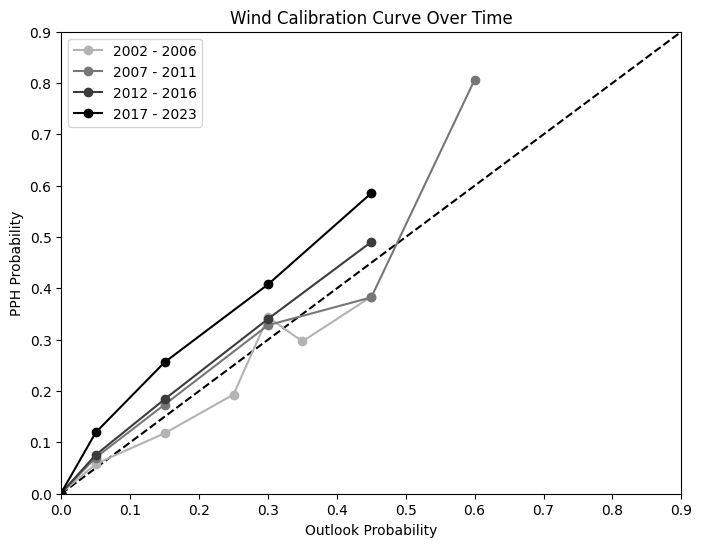

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


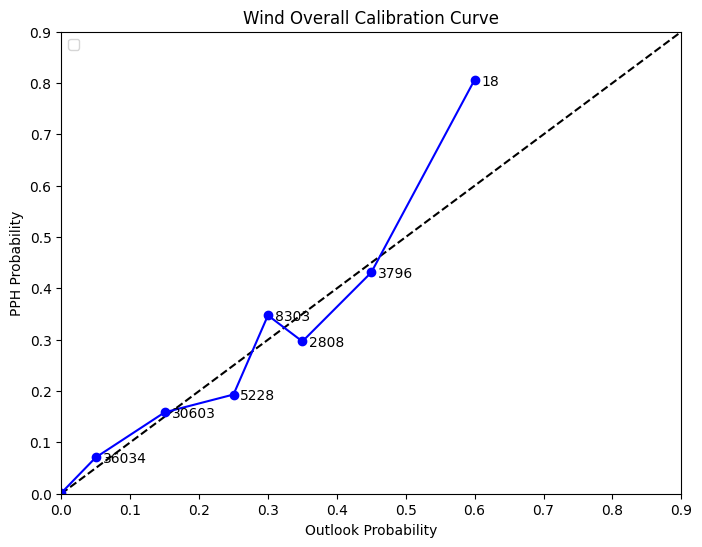

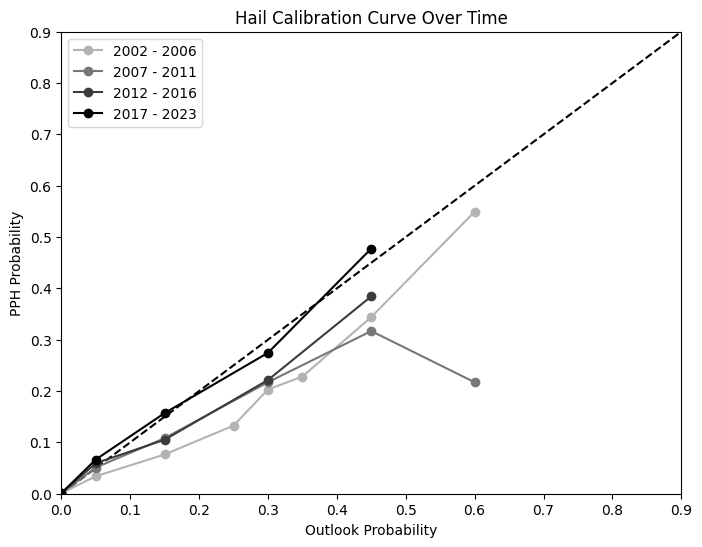

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


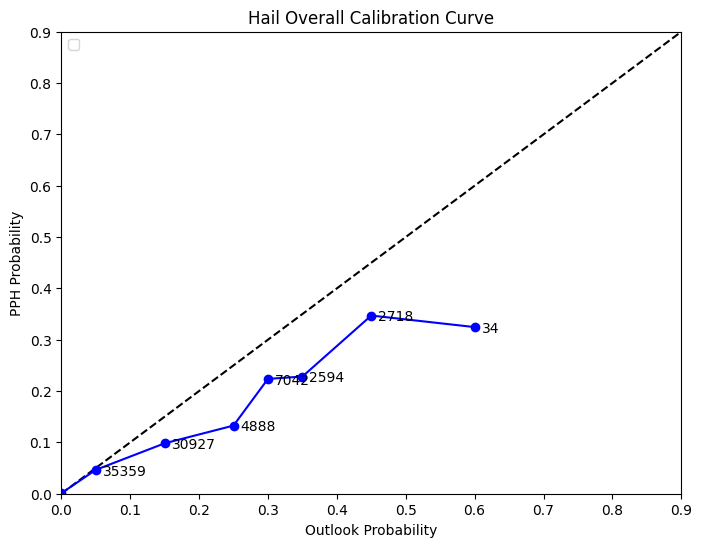

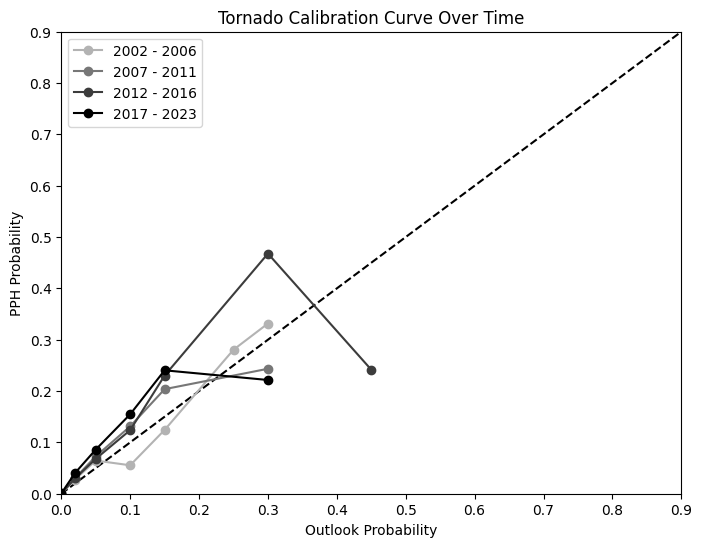

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


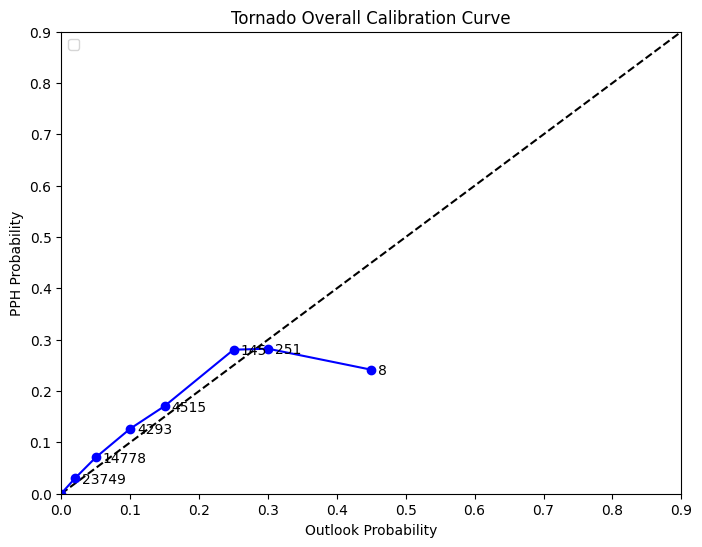

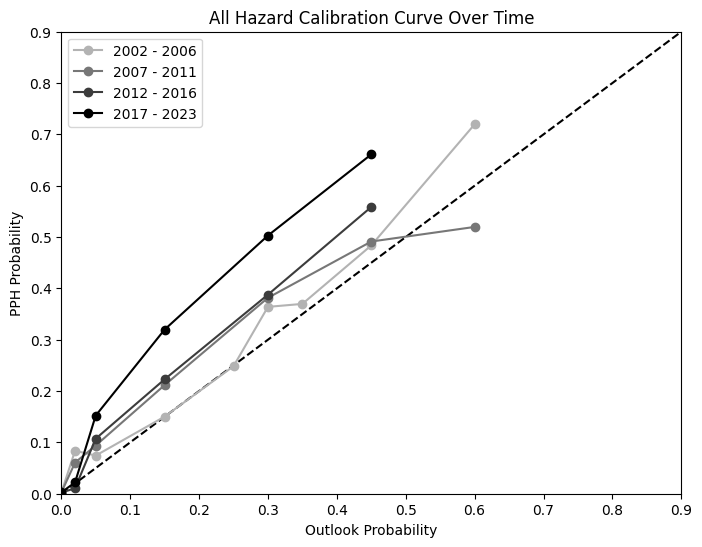

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


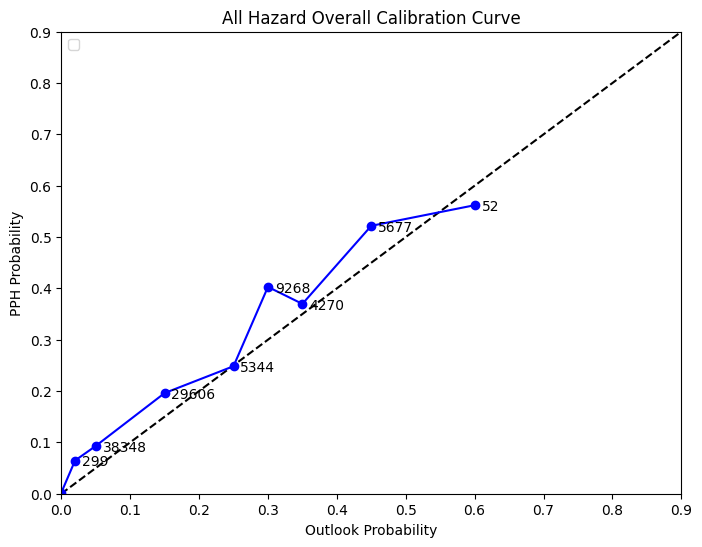

In [136]:
for haz in hazards:
    pph_probs = []
    outlook_probs = []
    labels = []
    colors = []
    greys = np.linspace(.7, 0, len(time_periods))
    for i, time_period in enumerate(time_periods):
        if time_period != 'all':
            year1 = time_period.split('_')[0]
            year2 = time_period.split('_')[1]
            this_pph = curr_pph.sel(time = (curr_pph['time'] >= year1 + '01010000') & (curr_pph['time'] <= year2 + '12312359'))
            this_outlooks = curr_outlooks.sel(time = (curr_outlooks['time'] >= year1 + '01010000') & (curr_outlooks['time'] <= year2 + '12312359'))
        else:
            year1 = '2002'
            year2 = '2023'
            this_pph = curr_pph
            this_outlooks = curr_outlooks
        pph_probs.append(this_pph[pph_key_dict[haz]] / 100)
        outlook_probs.append(this_outlooks.sel(outlook = outlook_key_dict[haz])['prob'])
        labels.append(year1 + ' - ' + year2)
        colors.append(str(greys[i]))
    make_calibration_curve(pph_probs, outlook_probs, haz + ' Calibration Curve Over Time', labels, colors, save = True, save_title = 'calibration_curve_' + haz + '_over_time' + ('_mdt' if mod else '_all'))

    make_calibration_curve([curr_pph[pph_key_dict[haz]] / 100], [curr_outlooks.sel(outlook = outlook_key_dict[haz])['prob']], haz + ' Overall Calibration Curve', [None], ['blue'], save = True, save_title = ('calibration_curve_' + haz + ('_mdt' if mod else '_all')), counts = True)
